In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Lessons learnt:


1.   Normalize data
2.   Augment data
3.   Include dropout rate to avoid overfitting
4.   Use discriminative learning rates



## Getting Data

In [3]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_177.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_32.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_239.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_147.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Persian_174.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=256)

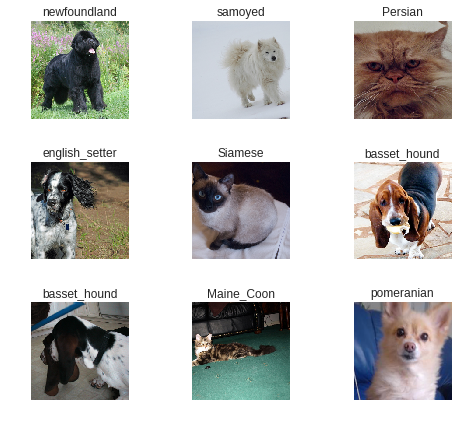

In [7]:
data.show_batch(rows=3, figsize=(7,6))

In [8]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Data Augmentation
Side note: I tried with and without augmentation and got better results using it.

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [0]:
path = untar_data(URLs.PETS)/'images'
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [0]:
bs=64
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
#training with low res images first
data = get_data(128, bs, 'zeros')

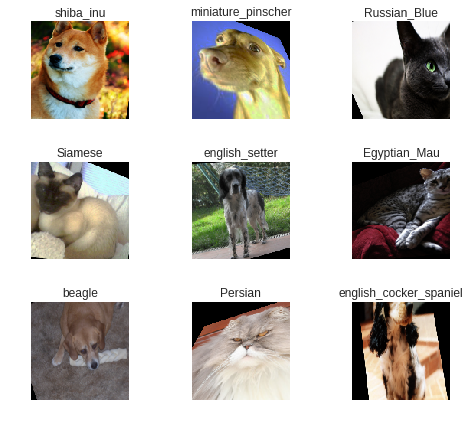

In [14]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Abyssinian',
  'Bengal',
  'Birman',
  'Bombay',
  'British_Shorthair',
  'Egyptian_Mau',
  'Maine_Coon',
  'Persian',
  'Ragdoll',
  'Russian_Blue',
  'Siamese',
  'Sphynx',
  'american_bulldog',
  'american_pit_bull_terrier',
  'basset_hound',
  'beagle',
  'boxer',
  'chihuahua',
  'english_cocker_spaniel',
  'english_setter',
  'german_shorthaired',
  'great_pyrenees',
  'havanese',
  'japanese_chin',
  'keeshond',
  'leonberger',
  'miniature_pinscher',
  'newfoundland',
  'pomeranian',
  'pug',
  'saint_bernard',
  'samoyed',
  'scottish_terrier',
  'shiba_inu',
  'staffordshire_bull_terrier',
  'wheaten_terrier',
  'yorkshire_terrier'],
 37,
 5912,
 1478)

## Using NOT pretrained resnet34

In [15]:
#saving models in google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'
path1 = Path(base_dir + 'data/pets')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#manually setting dropout rate
learn = create_cnn(data, models.resnet34, metrics=error_rate,pretrained = False, ps=0.5, bn_final=True)

In [17]:
# Defining a specific learning rate and the iterations per epoch for which I want them to increase and decrease
# using pct_start
learn.fit_one_cycle(50, slice(1e-2), pct_start=0.8)
learn.save(path1/'untrained-stage-1-v5')

epoch,train_loss,valid_loss,error_rate
1,3.752548,3.635889,0.961434
2,3.700139,3.576133,0.959405
3,3.644083,3.525646,0.953315
4,3.578540,3.479718,0.936401
5,3.511455,3.408666,0.921516
6,3.461529,3.372978,0.916779
7,3.403903,3.273014,0.893775
8,3.351888,3.222367,0.871448
9,3.295575,3.199948,0.878214
10,3.255965,3.121909,0.851827


In [18]:
learn.load(path1/'untrained-stage-1-v5')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Ragdoll,basset_hound,Maine_Coon,Ragdoll,english_setter
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
chihuahua,beagle,yorkshire_terrier,Abyssinian,yorkshire_terrier
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3)

In [0]:
#getting high res data
data = get_data(224, 128, 'zeros')

In [0]:
learn.unfreeze()

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-05


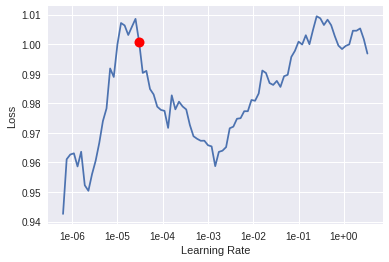

In [22]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(20, slice(1e-6,1e-4), pct_start=0.05)
learn.save(path1/'untrained-stage-2-v5');

epoch,train_loss,valid_loss,error_rate
1,0.992594,0.878216,0.278755
2,1.007967,0.872817,0.274696
3,0.958390,0.873273,0.276049
4,0.981002,0.871503,0.276049
5,0.987118,0.878100,0.276049
6,0.992441,0.874209,0.276725
7,0.987008,0.875398,0.276725
8,1.016962,0.878729,0.278078
9,1.006624,0.878232,0.280108
10,0.980402,0.875034,0.273342


In [26]:
print(accuracy(*learn.TTA()))

tensor(0.7497)


# Second iteration, with higher accuracy

In [0]:
#Training more epochs
learn.fit_one_cycle(20, slice(1e-2), pct_start=0.8)
learn.save(path1/'untrained-stage-1-v4')

epoch,train_loss,valid_loss,error_rate
1,2.871437,2.708964,0.751691
2,2.854336,2.706915,0.760487
3,2.809340,2.734272,0.763193
4,2.793573,2.678449,0.751691
5,2.752668,2.582700,0.713802
6,2.725718,2.591848,0.721245
7,2.721376,2.608413,0.740189
8,2.679476,2.827230,0.790257
9,2.619615,3.075845,0.800406
10,2.575232,2.576098,0.740866


In [0]:
#Training more epochs
learn.fit_one_cycle(20, slice(1e-2), pct_start=0.8)
learn.save(path1/'untrained-stage-1-v4')

epoch,train_loss,valid_loss,error_rate
1,1.724136,1.236584,0.376184
2,1.711785,1.243433,0.374154
3,1.705599,1.239112,0.375507
4,1.720924,1.233619,0.374831
5,1.713055,1.242002,0.375507
6,1.720813,1.238817,0.376184
7,1.719682,1.237600,0.374831
8,1.684653,1.244778,0.374831
9,1.712848,1.237133,0.377537
10,1.706625,1.239877,0.375507


In [0]:
#Loading the better model
learn.load(path1/'untrained-stage-1-v4')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (5912 items)
[Category staffordshire_bull_terrier, Category newfoundland, Category Abyssinian, Category havanese, Category american_pit_bull_terrier]...
Path: /root/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (5912 items)
[Image (3, 375, 500), Image (3, 375, 500), Image (3, 473, 600), Image (3, 334, 500), Image (3, 300, 234)]...
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList
y: CategoryList (1478 items)
[Category havanese, Category beagle, Category Egyptian_Mau, Category beagle, Category havanese]...
Path: /root/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (1478 items)
[Image (3, 375, 500), Image (3, 375, 500), Image (3, 383, 321), Image (3, 375, 500), Image (3, 354, 500)]...
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


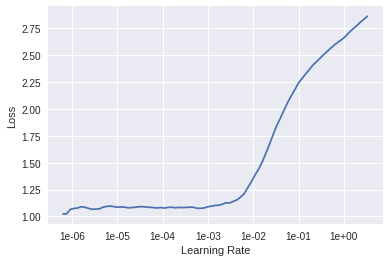

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(50, slice(1e-6,1e-4), pct_start=0.05)
learn.save(path1/'untrained-stage-2-v3');

epoch,train_loss,valid_loss,error_rate
1,1.076478,0.834171,0.248985
2,1.086070,0.828700,0.247632
3,1.059215,0.820947,0.248309
4,1.063298,0.822068,0.248309
5,1.074557,0.820154,0.239513
6,1.060763,0.814714,0.242219
7,1.052202,0.820044,0.247632
8,1.065150,0.819482,0.246955
9,1.063306,0.814094,0.240866
10,1.035995,0.811439,0.242219


Since we added dropout we can see that the train loss is higher (to avoid overfitting). however valid loss decreases with every epoch

In [0]:
#Training more epochs to see if error rate goes down
learn.fit_one_cycle(20, slice(1e-6,1e-4), pct_start=0.05)

epoch,train_loss,valid_loss,error_rate
1,1.049172,0.808752,0.242219
2,1.025713,0.814278,0.242219
3,1.045191,0.815065,0.244249
4,1.038734,0.807482,0.236806
5,1.037407,0.811652,0.244249
6,1.030930,0.800797,0.236130
7,1.021737,0.802397,0.237483
8,1.009463,0.801565,0.234777
9,1.032798,0.803633,0.237483
10,1.023598,0.803048,0.242219


In [0]:
#increasing learning rate and checking
learn.fit_one_cycle(10, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.990358,0.779526,0.232070
2,0.982005,0.773610,0.230041
3,0.991986,0.770901,0.227334
4,0.957905,0.768963,0.229364
5,0.977341,0.773657,0.228011
6,0.987650,0.768523,0.229364
7,1.002999,0.767433,0.227334
8,0.985339,0.769379,0.228687
9,0.983759,0.766885,0.230041
10,0.972010,0.771517,0.234100


In [0]:
print(accuracy(*learn.TTA()))

tensor(0.7876)
